<a href="https://colab.research.google.com/github/whiperyn/Adversarial-Training-Simple-Diffusion-Model/blob/main/adversarial_training_and_simple_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install projects

In [ ]:
pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.1 MB/s eta 0:00:00


In [ ]:
pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.0 MB/s eta 0:00:00


##Adversarial Training

Import libraries

In [ ]:
import torch
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.models as models
import umap
from tqdm import tqdm
import torch.nn as nn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import random
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

###Load Data

Used CIFAR-10 dataset. Splited 20% of the data for training and the rest for validation.

In [ ]:
Train_SIZE = 0.2
cifar_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize( (0.5,0.5,0.5),(0.5,0.5,0.5))])
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class Cifar10Dataset(torch.utils.data.Dataset):

    def __init__(self,dataset,idx,transforms=None):
        self.idx = idx
        self.transforms = transforms
        self.data = torch.utils.data.Subset(dataset, idx)

    def __getitem__(self,index):
        image,label = self.data[index]
        if(self.transforms!= None):
            image = self.transforms(image)

        return image,label

    def __len__(self):
        return len(self.data)

#Split data and create the dataloader
train_labels = [label for _, label in cifar_trainset]
test_labels = [label for _, label in cifar_testset]

train_idx, valid_idx = train_test_split(
    np.arange(len(train_labels)),
    test_size=0.8,
    random_state=42,
    stratify=train_labels
)


train_dataset = Cifar10Dataset(cifar_trainset, train_idx, transforms=cifar_transforms)
valid_dataset = Cifar10Dataset(cifar_trainset, valid_idx, transforms=cifar_transforms)
test_dataset = Cifar10Dataset(cifar_testset, np.arange(len(cifar_testset)), transforms=cifar_transforms)

# dataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# test_loader = DataLoader(cifar_testset, batch_size=64, shuffle=False)

###Train Model

Train a ResNet18 model using the cross-entropy loss function, and report its accuracy on validation and test datasets.

After that, reduce the dimensionality of the output of the backbone of the network and visualize it for the unseen data. Used UMAP for dimensionality reduction.

In [ ]:
class Resnet18(nn.Module):
    def __init__(self, num_classes,normalize = False):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
      x = self.model.conv1(x)
      x = self.model.bn1(x)
      x = self.model.relu(x)
      x = self.model.maxpool(x)

      x = self.model.layer1(x)
      x = self.model.layer2(x)
      x = self.model.layer3(x)
      x = self.model.layer4(x)

      x = self.model.avgpool(x)
      x = torch.flatten(x, 1)
      x = self.model.fc(x)
      return x

In [ ]:
def train(model,data_loader,criterion,optimizer,attack = False):

      model.train()
      running_loss = 0.0
      correct = 0
      total = 0

      with tqdm(data_loader, desc ="   train") as train_tqdm:
          for batch_idx, (inputs, targets) in enumerate(train_tqdm):
              inputs, targets = inputs.to(device), targets.to(device)
              optimizer.zero_grad()
              outputs = model(inputs)
              loss = criterion(outputs, targets)
              loss.backward()
              optimizer.step()
              running_loss += loss.item()
              _, predicted = outputs.max(1)
              total += targets.size(0)
              correct += predicted.eq(targets).sum().item()

      average_train_loss = running_loss / len(data_loader)
      accuracy = 100 * correct / total



      return average_train_loss, accuracy

In [ ]:
def test(model,data_loader,criterion,optimizer,attack=False):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(data_loader, desc ="   test") as test_tqdm:
        for batch_idx, (inputs, targets) in enumerate(test_tqdm):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute the loss

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    average_test_loss = running_loss / len(data_loader)
    accuracy = 100. * correct / total

    return average_test_loss, accuracy

In [ ]:
def extract_features(model, data_loader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            output = model(inputs)
            features.extend(output.cpu().detach().numpy())
            labels.extend(targets.cpu().numpy())

    return np.array(features), np.array(labels)




def plot_umap(features,y):
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(features)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='Spectral', s=5)
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
    plt.title('UMAP projection')
    plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
   train: 100%|██████████| 157/157 [00:08<00:00, 18.78it/s]


Epoch: 1, Loss: 1.3455, Accuracy: 54.38%


   train: 100%|██████████| 157/157 [00:07<00:00, 21.68it/s]


Epoch: 2, Loss: 0.8979, Accuracy: 70.25%


   train: 100%|██████████| 157/157 [00:04<00:00, 32.11it/s]


Epoch: 3, Loss: 0.7210, Accuracy: 76.06%


   train: 100%|██████████| 157/157 [00:04<00:00, 35.02it/s]


Epoch: 4, Loss: 0.5779, Accuracy: 81.08%


   train: 100%|██████████| 157/157 [00:05<00:00, 30.99it/s]


Epoch: 5, Loss: 0.4585, Accuracy: 85.34%


   train: 100%|██████████| 157/157 [00:04<00:00, 36.22it/s]


Epoch: 6, Loss: 0.3716, Accuracy: 87.74%


   train: 100%|██████████| 157/157 [00:04<00:00, 33.36it/s]


Epoch: 7, Loss: 0.2882, Accuracy: 90.65%


   train: 100%|██████████| 157/157 [00:05<00:00, 26.67it/s]


Epoch: 8, Loss: 0.2573, Accuracy: 91.59%


   train: 100%|██████████| 157/157 [00:04<00:00, 36.01it/s]


Epoch: 9, Loss: 0.1951, Accuracy: 93.50%


   train: 100%|██████████| 157/157 [00:04<00:00, 31.94it/s]


Epoch: 10, Loss: 0.1816, Accuracy: 94.12%


   train: 100%|██████████| 157/157 [00:04<00:00, 35.97it/s]


Epoch: 11, Loss: 0.1454, Accuracy: 95.30%


   train: 100%|██████████| 157/157 [00:05<00:00, 30.73it/s]


Epoch: 12, Loss: 0.1829, Accuracy: 94.42%


   train: 100%|██████████| 157/157 [00:04<00:00, 34.71it/s]


Epoch: 13, Loss: 0.1019, Accuracy: 96.62%


   train: 100%|██████████| 157/157 [00:04<00:00, 35.77it/s]


Epoch: 14, Loss: 0.1112, Accuracy: 96.44%


   train: 100%|██████████| 157/157 [00:05<00:00, 30.75it/s]


Epoch: 15, Loss: 0.1200, Accuracy: 96.20%


   train: 100%|██████████| 157/157 [00:04<00:00, 36.85it/s]


Epoch: 16, Loss: 0.0941, Accuracy: 97.03%


   train: 100%|██████████| 157/157 [00:04<00:00, 32.95it/s]


Epoch: 17, Loss: 0.0754, Accuracy: 97.69%


   train: 100%|██████████| 157/157 [00:04<00:00, 33.98it/s]


Epoch: 18, Loss: 0.0869, Accuracy: 97.16%


   train: 100%|██████████| 157/157 [00:04<00:00, 34.93it/s]


Epoch: 19, Loss: 0.0622, Accuracy: 98.18%


   train: 100%|██████████| 157/157 [00:05<00:00, 30.65it/s]


Epoch: 20, Loss: 0.1722, Accuracy: 94.51%


   train: 100%|██████████| 157/157 [00:04<00:00, 34.89it/s]


Epoch: 21, Loss: 0.0655, Accuracy: 97.93%


   train: 100%|██████████| 157/157 [00:04<00:00, 34.31it/s]


Epoch: 22, Loss: 0.0610, Accuracy: 98.16%


   train: 100%|██████████| 157/157 [00:04<00:00, 31.65it/s]


Epoch: 23, Loss: 0.0553, Accuracy: 98.34%


   train: 100%|██████████| 157/157 [00:04<00:00, 36.33it/s]


Epoch: 24, Loss: 0.1155, Accuracy: 96.27%


   train: 100%|██████████| 157/157 [00:05<00:00, 31.19it/s]


Epoch: 25, Loss: 0.0658, Accuracy: 97.92%


   train: 100%|██████████| 157/157 [00:04<00:00, 36.53it/s]


Epoch: 26, Loss: 0.0591, Accuracy: 98.26%


   train: 100%|██████████| 157/157 [00:04<00:00, 36.82it/s]


Epoch: 27, Loss: 0.0858, Accuracy: 97.74%


   train: 100%|██████████| 157/157 [00:04<00:00, 31.95it/s]


Epoch: 28, Loss: 0.1687, Accuracy: 95.31%


   train: 100%|██████████| 157/157 [00:04<00:00, 35.02it/s]


Epoch: 29, Loss: 0.0347, Accuracy: 98.91%


   train: 100%|██████████| 157/157 [00:05<00:00, 31.23it/s]


Epoch: 30, Loss: 0.0314, Accuracy: 99.11%


   train: 100%|██████████| 157/157 [00:05<00:00, 27.30it/s]


Epoch: 31, Loss: 0.0632, Accuracy: 98.08%


   train: 100%|██████████| 157/157 [00:04<00:00, 34.34it/s]


Epoch: 32, Loss: 0.0308, Accuracy: 98.94%


   train: 100%|██████████| 157/157 [00:04<00:00, 32.35it/s]


Epoch: 33, Loss: 0.0245, Accuracy: 99.23%


   train: 100%|██████████| 157/157 [00:04<00:00, 36.66it/s]


Epoch: 34, Loss: 0.0259, Accuracy: 99.27%


   train: 100%|██████████| 157/157 [00:05<00:00, 31.26it/s]


Epoch: 35, Loss: 0.0474, Accuracy: 98.50%


   test: 100%|██████████| 625/625 [00:13<00:00, 46.84it/s]


Validation Loss: 1.3140, Accuracy: 72.92%


   test: 100%|██████████| 157/157 [00:03<00:00, 48.99it/s]


Test - Loss: 1.3350, Accuracy: 72.39%


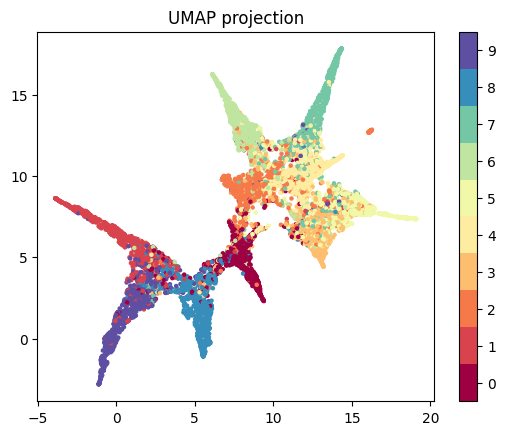

In [ ]:
num_classes = 10
model = Resnet18(num_classes=num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 35
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    print(f"Epoch: {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

valid_loss, valid_accuracy = test(model, valid_loader, criterion, optimizer)
print(f'Validation Loss: {valid_loss:.4f}, Accuracy: {valid_accuracy:.2f}%')
test_loss, test_accuracy = test(model, test_loader, criterion, optimizer)
print(f"Test - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")



features, y_test = extract_features(model, test_loader)

plot_umap(features,y_test)

###Adversarial Test


Changed the unseen data before calculating the accuracy of them from the output image of the backbone. Compare the results with the previous section. Changes include data augmentations such as adding Gaussian noise, color jitter, etc. Applied an adversarial attack such as fast gradient method on the network.

In [ ]:
# added
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


augmentation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.1)])


In [ ]:
def generate_fgm_examples(model,data_loader,criterion):
    model.eval()
    examples = []
    labels = []
    epsilon = 0.01
    total = 0
    correct = 0

    with tqdm(data_loader) as test_tqdm:
        for batch_idx, (inputs, targets) in enumerate(test_tqdm):
            inputs, targets = inputs.to(device), targets.to(device)
            original_inputs = inputs.clone()
            for i in range(inputs.size(0)):
                inputs[i] = augmentation(inputs[i].cpu()).to(device)

            inputs.requires_grad = True
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            model.zero_grad()
            loss.backward()

            adv_inputs = inputs + epsilon * inputs.grad.sign()
            adv_inputs = torch.clamp(adv_inputs, 0, 1)

            adv_outputs = model(adv_inputs)
            _, predicted = torch.max(adv_outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            examples.extend(adv_inputs.detach().cpu().numpy())
            labels.extend(targets.detach().cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy:.2f}%')

    return np.array(examples), np.array(labels)


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Accuracy on adversarial examples: 1.01%


   test: 100%|██████████| 157/157 [00:00<00:00, 204.03it/s]


Original tested on adv tests: Test - Loss: 9.4154, Accuracy: 1.01%


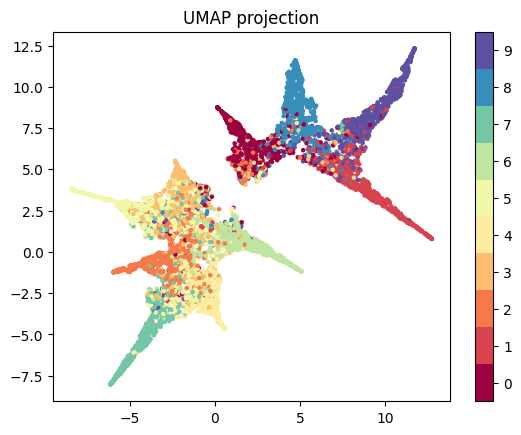

In [ ]:

advx_test, advy_test = generate_fgm_examples(model, test_loader, criterion)
advx_test_tensor = torch.tensor(advx_test, dtype=torch.float).to(device)
advy_test_tensor = torch.tensor(advy_test, dtype=torch.long).to(device)

adv_test_dataset = TensorDataset(advx_test_tensor, advy_test_tensor)
adv_test_loader = DataLoader(adv_test_dataset, batch_size=64, shuffle=False)
test_loss, test_accuracy = test(model, adv_test_loader, criterion, optimizer)
print(f"Original tested on adv tests: Test - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")

features_new, y_new = extract_features(model, test_loader)

plot_umap(features_new, y_new)

##Adversarial Train


Repeated the experiments on parts two and three using adversarial examples and compare the results. Here, the training data will be modified using augmentations and adversarial attack.

In [ ]:
# original

num_classes = 10
model = Resnet18(num_classes=num_classes).to(device)

# adv data
num_classes = 10
model = Resnet18(num_classes=num_classes).to(device)
advx_train, advy_train = generate_fgm_examples(model, train_loader, criterion)
advx_train_tensor = torch.tensor(advx_train, dtype=torch.float).to(device)
advy_train_tensor = torch.tensor(advy_train, dtype=torch.long).to(device)

adv_train_dataset = TensorDataset(advx_train_tensor, advy_train_tensor)
adv_train_loader = DataLoader(adv_train_dataset, batch_size=64, shuffle=True)

advx_valid, advy_valid = generate_fgm_examples(model, valid_loader, criterion)
advx_valid_tensor = torch.tensor(advx_valid, dtype=torch.float).to(device)
advy_valid_tensor = torch.tensor(advy_valid, dtype=torch.long).to(device)

adv_valid_dataset = TensorDataset(advx_valid_tensor, advy_valid_tensor)
adv_valid_loader = DataLoader(adv_valid_dataset, batch_size=64, shuffle=False)

advx_test, advy_test = generate_fgm_examples(model, test_loader, criterion)
advx_test_tensor = torch.tensor(advx_test, dtype=torch.float).to(device)
advy_test_tensor = torch.tensor(advy_test, dtype=torch.long).to(device)

adv_test_dataset = TensorDataset(advx_test_tensor, advy_test_tensor)
adv_test_loader = DataLoader(adv_test_dataset, batch_size=64, shuffle=False)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 35
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    print(f"Original: Epoch: {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

valid_loss, valid_accuracy = test(model, valid_loader, criterion, optimizer)
print(f'Original: Validation Loss: {valid_loss:.4f}, Accuracy: {valid_accuracy:.2f}%')
test_loss, test_accuracy = test(model, test_loader, criterion, optimizer)
print(f"Original: Test - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")
test_loss, test_accuracy = test(model, adv_test_loader, criterion, optimizer)
print(f"Original tested on adv tests: Test - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")



features, y_test = extract_features(model, test_loader)

# augmented
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, adv_train_loader, criterion, optimizer)
    print(f"Adv: Epoch: {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

valid_loss, valid_accuracy = test(model, adv_valid_loader, criterion, optimizer)
print(f'Adv: Validation Loss: {valid_loss:.4f}, Accuracy: {valid_accuracy:.2f}%')
test_loss, test_accuracy = test(model, adv_test_loader, criterion, optimizer)
print(f"Adv: Test - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")
test_loss, test_accuracy = test(model, test_loader, criterion, optimizer)
print(f"Adv data tested on original tests: Test - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")

features2, y_test2 = extract_features(model, adv_test_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 157/157 [00:28<00:00,  5.49it/s]


Accuracy on adversarial examples: 1.19%


100%|██████████| 625/625 [01:27<00:00,  7.11it/s]


Accuracy on adversarial examples: 1.35%


100%|██████████| 157/157 [00:21<00:00,  7.17it/s]


Accuracy on adversarial examples: 1.24%


   train: 100%|██████████| 157/157 [00:04<00:00, 36.50it/s]


Original: Epoch: 1, Loss: 1.3314, Accuracy: 54.50%


   train: 100%|██████████| 157/157 [00:04<00:00, 32.10it/s]


Original: Epoch: 2, Loss: 0.8945, Accuracy: 70.43%


   train: 100%|██████████| 157/157 [00:04<00:00, 37.01it/s]


Original: Epoch: 3, Loss: 0.7148, Accuracy: 76.22%


   train: 100%|██████████| 157/157 [00:04<00:00, 31.53it/s]


Original: Epoch: 4, Loss: 0.5428, Accuracy: 82.01%


   train: 100%|██████████| 157/157 [00:04<00:00, 35.38it/s]


Original: Epoch: 5, Loss: 0.4368, Accuracy: 85.11%


   train: 100%|██████████| 157/157 [00:04<00:00, 36.66it/s]


Original: Epoch: 6, Loss: 0.3266, Accuracy: 89.05%


   train: 100%|██████████| 157/157 [00:04<00:00, 32.67it/s]


Original: Epoch: 7, Loss: 0.2575, Accuracy: 91.49%


   train: 100%|██████████| 157/157 [00:04<00:00, 37.15it/s]


Original: Epoch: 8, Loss: 0.2269, Accuracy: 92.59%


   train: 100%|██████████| 157/157 [00:04<00:00, 34.18it/s]


Original: Epoch: 9, Loss: 0.1919, Accuracy: 93.80%


   train: 100%|██████████| 157/157 [00:04<00:00, 33.29it/s]


Original: Epoch: 10, Loss: 0.1543, Accuracy: 95.04%


   train: 100%|██████████| 157/157 [00:04<00:00, 36.66it/s]


Original: Epoch: 11, Loss: 0.1557, Accuracy: 95.06%


   train: 100%|██████████| 157/157 [00:04<00:00, 32.36it/s]


Original: Epoch: 12, Loss: 0.1662, Accuracy: 94.82%


   train: 100%|██████████| 157/157 [00:04<00:00, 37.03it/s]


Original: Epoch: 13, Loss: 0.1341, Accuracy: 95.89%


   train: 100%|██████████| 157/157 [00:04<00:00, 37.18it/s]


Original: Epoch: 14, Loss: 0.1276, Accuracy: 95.88%


   train: 100%|██████████| 157/157 [00:04<00:00, 32.03it/s]


Original: Epoch: 15, Loss: 0.1040, Accuracy: 96.59%


   train: 100%|██████████| 157/157 [00:04<00:00, 35.81it/s]


Original: Epoch: 16, Loss: 0.0725, Accuracy: 97.59%


   train: 100%|██████████| 157/157 [00:04<00:00, 34.45it/s]


Original: Epoch: 17, Loss: 0.0793, Accuracy: 97.42%


   train: 100%|██████████| 157/157 [00:04<00:00, 34.84it/s]


Original: Epoch: 18, Loss: 0.0739, Accuracy: 97.67%


   train: 100%|██████████| 157/157 [00:04<00:00, 36.79it/s]


Original: Epoch: 19, Loss: 0.0817, Accuracy: 97.45%


   train: 100%|██████████| 157/157 [00:04<00:00, 32.62it/s]


Original: Epoch: 20, Loss: 0.0932, Accuracy: 97.19%


   train: 100%|██████████| 157/157 [00:04<00:00, 36.27it/s]


Original: Epoch: 21, Loss: 0.0812, Accuracy: 97.61%


   train: 100%|██████████| 157/157 [00:04<00:00, 35.34it/s]


Original: Epoch: 22, Loss: 0.0747, Accuracy: 97.62%


   train: 100%|██████████| 157/157 [00:04<00:00, 32.64it/s]


Original: Epoch: 23, Loss: 0.0627, Accuracy: 97.97%


   train: 100%|██████████| 157/157 [00:04<00:00, 36.20it/s]


Original: Epoch: 24, Loss: 0.0670, Accuracy: 97.91%


   train: 100%|██████████| 157/157 [00:04<00:00, 32.33it/s]


Original: Epoch: 25, Loss: 0.0779, Accuracy: 97.66%


   train: 100%|██████████| 157/157 [00:04<00:00, 37.09it/s]


Original: Epoch: 26, Loss: 0.0715, Accuracy: 97.84%


   train: 100%|██████████| 157/157 [00:04<00:00, 36.54it/s]


Original: Epoch: 27, Loss: 0.0598, Accuracy: 98.08%


   train: 100%|██████████| 157/157 [00:04<00:00, 32.86it/s]


Original: Epoch: 28, Loss: 0.0557, Accuracy: 98.24%


   train: 100%|██████████| 157/157 [00:04<00:00, 35.63it/s]


Original: Epoch: 29, Loss: 0.0703, Accuracy: 97.76%


   train: 100%|██████████| 157/157 [00:04<00:00, 36.98it/s]


Original: Epoch: 30, Loss: 0.0821, Accuracy: 97.66%


   train: 100%|██████████| 157/157 [00:04<00:00, 32.37it/s]


Original: Epoch: 31, Loss: 0.0702, Accuracy: 97.71%


   train: 100%|██████████| 157/157 [00:04<00:00, 36.50it/s]


Original: Epoch: 32, Loss: 0.0514, Accuracy: 98.40%


   train: 100%|██████████| 157/157 [00:04<00:00, 32.84it/s]


Original: Epoch: 33, Loss: 0.0699, Accuracy: 97.85%


   train: 100%|██████████| 157/157 [00:04<00:00, 37.63it/s]


Original: Epoch: 34, Loss: 0.0363, Accuracy: 98.76%


   train: 100%|██████████| 157/157 [00:04<00:00, 37.81it/s]


Original: Epoch: 35, Loss: 0.0475, Accuracy: 98.82%


   test: 100%|██████████| 625/625 [00:13<00:00, 47.79it/s]


Original: Validation Loss: 1.3752, Accuracy: 73.04%


   test: 100%|██████████| 157/157 [00:03<00:00, 42.45it/s]


Original: Test - Loss: 1.4161, Accuracy: 72.71%


   test: 100%|██████████| 157/157 [00:00<00:00, 210.82it/s]


Original tested on adv tests: Test - Loss: 5.2995, Accuracy: 15.40%


   train: 100%|██████████| 157/157 [00:01<00:00, 86.85it/s]


Adv: Epoch: 1, Loss: 2.5080, Accuracy: 20.33%


   train: 100%|██████████| 157/157 [00:01<00:00, 86.78it/s]


Adv: Epoch: 2, Loss: 1.9264, Accuracy: 30.85%


   train: 100%|██████████| 157/157 [00:01<00:00, 81.82it/s]


Adv: Epoch: 3, Loss: 1.6555, Accuracy: 41.46%


   train: 100%|██████████| 157/157 [00:02<00:00, 70.91it/s]


Adv: Epoch: 4, Loss: 1.3666, Accuracy: 51.28%


   train: 100%|██████████| 157/157 [00:01<00:00, 86.67it/s]


Adv: Epoch: 5, Loss: 1.0538, Accuracy: 63.54%


   train: 100%|██████████| 157/157 [00:01<00:00, 88.07it/s]


Adv: Epoch: 6, Loss: 0.7863, Accuracy: 72.89%


   train: 100%|██████████| 157/157 [00:01<00:00, 81.93it/s]


Adv: Epoch: 7, Loss: 0.5869, Accuracy: 79.51%


   train: 100%|██████████| 157/157 [00:01<00:00, 87.71it/s]


Adv: Epoch: 8, Loss: 0.4037, Accuracy: 86.37%


   train: 100%|██████████| 157/157 [00:01<00:00, 86.79it/s]


Adv: Epoch: 9, Loss: 0.3222, Accuracy: 88.81%


   train: 100%|██████████| 157/157 [00:02<00:00, 66.58it/s]


Adv: Epoch: 10, Loss: 0.2360, Accuracy: 92.17%


   train: 100%|██████████| 157/157 [00:01<00:00, 86.00it/s]


Adv: Epoch: 11, Loss: 0.1876, Accuracy: 93.81%


   train: 100%|██████████| 157/157 [00:01<00:00, 85.92it/s]


Adv: Epoch: 12, Loss: 0.1661, Accuracy: 94.35%


   train: 100%|██████████| 157/157 [00:01<00:00, 84.29it/s]


Adv: Epoch: 13, Loss: 0.1344, Accuracy: 95.70%


   train: 100%|██████████| 157/157 [00:01<00:00, 86.51it/s]


Adv: Epoch: 14, Loss: 0.4830, Accuracy: 85.26%


   train: 100%|██████████| 157/157 [00:01<00:00, 87.41it/s]


Adv: Epoch: 15, Loss: 0.1133, Accuracy: 96.51%


   train: 100%|██████████| 157/157 [00:02<00:00, 66.41it/s]


Adv: Epoch: 16, Loss: 0.0969, Accuracy: 97.11%


   train: 100%|██████████| 157/157 [00:01<00:00, 86.62it/s]


Adv: Epoch: 17, Loss: 0.1434, Accuracy: 95.41%


   train: 100%|██████████| 157/157 [00:01<00:00, 84.65it/s]


Adv: Epoch: 18, Loss: 0.1198, Accuracy: 96.32%


   train: 100%|██████████| 157/157 [00:01<00:00, 82.95it/s]


Adv: Epoch: 19, Loss: 0.0582, Accuracy: 98.10%


   train: 100%|██████████| 157/157 [00:01<00:00, 85.79it/s]


Adv: Epoch: 20, Loss: 0.0537, Accuracy: 98.38%


   train: 100%|██████████| 157/157 [00:01<00:00, 80.60it/s]


Adv: Epoch: 21, Loss: 0.0719, Accuracy: 97.60%


   train: 100%|██████████| 157/157 [00:02<00:00, 65.44it/s]


Adv: Epoch: 22, Loss: 0.0455, Accuracy: 98.69%


   train: 100%|██████████| 157/157 [00:01<00:00, 81.95it/s]


Adv: Epoch: 23, Loss: 0.0616, Accuracy: 97.96%


   train: 100%|██████████| 157/157 [00:01<00:00, 86.30it/s]


Adv: Epoch: 24, Loss: 0.1019, Accuracy: 96.65%


   train: 100%|██████████| 157/157 [00:01<00:00, 86.24it/s]


Adv: Epoch: 25, Loss: 0.1016, Accuracy: 97.02%


   train: 100%|██████████| 157/157 [00:01<00:00, 85.65it/s]


Adv: Epoch: 26, Loss: 0.0451, Accuracy: 98.76%


   train: 100%|██████████| 157/157 [00:01<00:00, 86.68it/s]


Adv: Epoch: 27, Loss: 0.0702, Accuracy: 97.90%


   train: 100%|██████████| 157/157 [00:02<00:00, 69.88it/s]


Adv: Epoch: 28, Loss: 0.0740, Accuracy: 97.60%


   train: 100%|██████████| 157/157 [00:02<00:00, 76.63it/s]


Adv: Epoch: 29, Loss: 0.0505, Accuracy: 98.30%


   train: 100%|██████████| 157/157 [00:01<00:00, 82.77it/s]


Adv: Epoch: 30, Loss: 0.0369, Accuracy: 98.81%


   train: 100%|██████████| 157/157 [00:01<00:00, 84.70it/s]


Adv: Epoch: 31, Loss: 0.0394, Accuracy: 98.82%


   train: 100%|██████████| 157/157 [00:01<00:00, 87.13it/s]


Adv: Epoch: 32, Loss: 0.0884, Accuracy: 97.06%


   train: 100%|██████████| 157/157 [00:01<00:00, 86.64it/s]


Adv: Epoch: 33, Loss: 0.0789, Accuracy: 97.49%


   train: 100%|██████████| 157/157 [00:02<00:00, 75.77it/s]


Adv: Epoch: 34, Loss: 0.0823, Accuracy: 97.42%


   train: 100%|██████████| 157/157 [00:02<00:00, 75.70it/s]


Adv: Epoch: 35, Loss: 0.0609, Accuracy: 98.09%


   test: 100%|██████████| 625/625 [00:02<00:00, 215.06it/s]


Adv: Validation Loss: 3.3623, Accuracy: 41.54%


   test: 100%|██████████| 157/157 [00:00<00:00, 211.43it/s]


Adv: Test - Loss: 3.4163, Accuracy: 41.89%


   test: 100%|██████████| 157/157 [00:03<00:00, 45.81it/s]


Adv data tested on original tests: Test - Loss: 6.8485, Accuracy: 22.29%


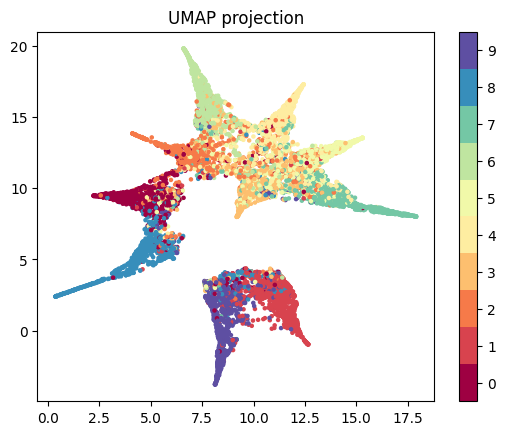

Train with original data and original tests


In [ ]:
plot_umap(features,y_test)
print("Train with original data and original tests")

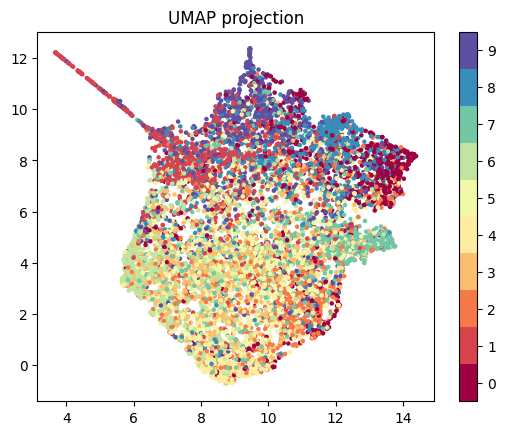

Train with augmented data and orginal tests


In [ ]:
plot_umap(features2,y_test)
print("Train with augmented data and orginal tests")

##Diffusion Model
Implemented a Denoising Diffusion Probabilistic Model (DDPM).  

Import libraries

In [ ]:
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import torch.nn as nn
from matplotlib import pyplot as plt
from PIL import Image
from keras.datasets import cifar10
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
import torch.nn.functional as F

###Load Data

Used one arbitrary class of CIFAR-10 dataset

In [ ]:
#Load the data and choose one class, then create the data loader.

Files already downloaded and verified


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image, label = self.images[idx]
        if self.transform is not None:
            #image = Image.fromarray(image)
            image = self.transform(image)

        return image, label

image_size = 32
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)


full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform = None)
first_image_label = full_dataset.targets[0] # this will get the first image class as the target class
class_name = full_dataset.classes[first_image_label]
print(class_name)

class_idx = full_dataset.class_to_idx[class_name]
filtered_images = [(img, label) for img, label in full_dataset if label == class_idx]


dataset = CustomDataset(filtered_images, transform=preprocess)

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
frog


In [ ]:
def show_images(x):
    x = x * 0.5 + 0.5
    grid = torchvision.utils.make_grid(x)
    grid = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid = Image.fromarray(np.array(grid).astype(np.uint8))
    return grid


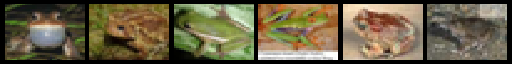

In [ ]:
images, labels = next(iter(dataloader)) # because I'm returning image, label
x_test = images[:6]
show_images(x_test).resize((8 * 64, 64), resample=Image.NEAREST)


###Forward pass

Implemented the forward pass of your diffusion model.

Noisied shape torch.Size([6, 3, 32, 32])


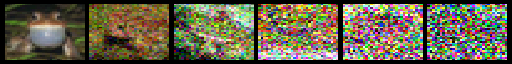

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=100) # timestep 100
timesteps = torch.linspace(0, 99, 6).long().to(device)
noise = torch.randn_like(x_test)
noisy_xtest = noise_scheduler.add_noise(x_test, noise, timesteps)
print("Noisied shape", noisy_xtest.shape)
show_images(noisy_xtest).resize((8 * 64, 64), resample=Image.NEAREST)

###Denoising

Implemented the denoising part of the diffusion model. Created a U-net and trained it on the CIFAR10 data. Then, start from random noise and plot the denoised images of 6 random samples.

In [ ]:
image_size = 32 #cifar
model = UNet2DModel( # followed tutorial
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)
model.to(device);

# check
with torch.no_grad():
  noisy_xtest = noisy_xtest.to(device)
  timesteps = timesteps.to(device)
  output = model(noisy_xtest, timesteps)
  model_prediction = output['sample'] if isinstance(output, dict) else output
model_prediction.shape

torch.Size([6, 3, 32, 32])

In [ ]:
noise_scheduler = DDPMScheduler(
      num_train_timesteps=100, beta_schedule="squaredcos_cap_v2"
)
def train(model,data_loader,criterion,optimizer):
    train_loss = []
    for epoch in range(35):  # because in q1 I'm using num_epochs = 35
        model.train()
        with tqdm(data_loader, desc="   train") as train_tqdm:
            for step, batch in enumerate(train_tqdm):
                optimizer.zero_grad()
                denoised = batch[0].to(device)  # because return image, label
                noise = torch.randn(denoised.shape, device=device)
                bs = denoised.shape[0]

                timesteps = torch.randint(
                    0, noise_scheduler.num_train_timesteps, (bs,), device=device
                ).long()

                noisied = noise_scheduler.add_noise(denoised, noise, timesteps)
                noise_pred = model(noisied, timesteps, return_dict=False)[0]
                loss = criterion(noise_pred, noise)
                loss.backward()
                train_loss.append(loss.item())
                optimizer.step()

        average_train_loss = sum(train_loss[-len(data_loader):]) / len(data_loader)
        print(f"Epoch:{epoch+1}, Loss: {average_train_loss:.4f}")

    return average_train_loss

# train data
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)
criterion = F.mse_loss
train(model, dataloader, criterion, optimizer)

   train:   0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
   train: 100%|██████████| 79/79 [00:09<00:00,  8.10it/s]


Epoch:1, Loss: 0.1772


   train: 100%|██████████| 79/79 [00:09<00:00,  8.21it/s]


Epoch:2, Loss: 0.0950


   train: 100%|██████████| 79/79 [00:09<00:00,  8.25it/s]


Epoch:3, Loss: 0.0857


   train: 100%|██████████| 79/79 [00:09<00:00,  8.52it/s]


Epoch:4, Loss: 0.0835


   train: 100%|██████████| 79/79 [00:09<00:00,  8.30it/s]


Epoch:5, Loss: 0.0796


   train: 100%|██████████| 79/79 [00:09<00:00,  8.24it/s]


Epoch:6, Loss: 0.0802


   train: 100%|██████████| 79/79 [00:09<00:00,  8.04it/s]


Epoch:7, Loss: 0.0759


   train: 100%|██████████| 79/79 [00:09<00:00,  8.29it/s]


Epoch:8, Loss: 0.0773


   train: 100%|██████████| 79/79 [00:09<00:00,  8.52it/s]


Epoch:9, Loss: 0.0768


   train: 100%|██████████| 79/79 [00:09<00:00,  8.33it/s]


Epoch:10, Loss: 0.0746


   train: 100%|██████████| 79/79 [00:09<00:00,  8.15it/s]


Epoch:11, Loss: 0.0743


   train: 100%|██████████| 79/79 [00:09<00:00,  8.39it/s]


Epoch:12, Loss: 0.0721


   train: 100%|██████████| 79/79 [00:09<00:00,  8.19it/s]


Epoch:13, Loss: 0.0715


   train: 100%|██████████| 79/79 [00:09<00:00,  8.54it/s]


Epoch:14, Loss: 0.0738


   train: 100%|██████████| 79/79 [00:09<00:00,  8.24it/s]


Epoch:15, Loss: 0.0732


   train: 100%|██████████| 79/79 [00:09<00:00,  8.20it/s]


Epoch:16, Loss: 0.0720


   train: 100%|██████████| 79/79 [00:09<00:00,  8.17it/s]


Epoch:17, Loss: 0.0703


   train: 100%|██████████| 79/79 [00:09<00:00,  8.19it/s]


Epoch:18, Loss: 0.0730


   train: 100%|██████████| 79/79 [00:09<00:00,  8.48it/s]


Epoch:19, Loss: 0.0687


   train: 100%|██████████| 79/79 [00:09<00:00,  8.37it/s]


Epoch:20, Loss: 0.0703


   train: 100%|██████████| 79/79 [00:09<00:00,  8.27it/s]


Epoch:21, Loss: 0.0700


   train: 100%|██████████| 79/79 [00:09<00:00,  8.29it/s]


Epoch:22, Loss: 0.0705


   train: 100%|██████████| 79/79 [00:09<00:00,  8.19it/s]


Epoch:23, Loss: 0.0706


   train: 100%|██████████| 79/79 [00:09<00:00,  8.33it/s]


Epoch:24, Loss: 0.0696


   train: 100%|██████████| 79/79 [00:09<00:00,  8.29it/s]


Epoch:25, Loss: 0.0697


   train: 100%|██████████| 79/79 [00:10<00:00,  7.79it/s]


Epoch:26, Loss: 0.0704


   train: 100%|██████████| 79/79 [00:09<00:00,  8.26it/s]


Epoch:27, Loss: 0.0710


   train: 100%|██████████| 79/79 [00:09<00:00,  8.22it/s]


Epoch:28, Loss: 0.0684


   train: 100%|██████████| 79/79 [00:09<00:00,  8.26it/s]


Epoch:29, Loss: 0.0694


   train: 100%|██████████| 79/79 [00:09<00:00,  8.32it/s]


Epoch:30, Loss: 0.0693


   train: 100%|██████████| 79/79 [00:09<00:00,  8.28it/s]


Epoch:31, Loss: 0.0697


   train: 100%|██████████| 79/79 [00:09<00:00,  8.16it/s]


Epoch:32, Loss: 0.0675


   train: 100%|██████████| 79/79 [00:09<00:00,  8.22it/s]


Epoch:33, Loss: 0.0677


   train: 100%|██████████| 79/79 [00:09<00:00,  8.11it/s]


Epoch:34, Loss: 0.0675


   train: 100%|██████████| 79/79 [00:09<00:00,  8.43it/s]

Epoch:35, Loss: 0.0687


0.06866912190106851

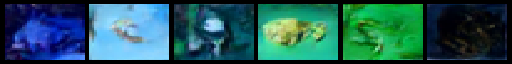

In [ ]:
sample = torch.randn(6, 3, 32, 32).to(device)

#denoise
for i, t in enumerate(noise_scheduler.timesteps):
    with torch.no_grad():
        res = model(sample, t).sample
    sample = noise_scheduler.step(res, t, sample).prev_sample

show_images(sample).resize((8 * 64, 64), resample=Image.NEAREST)